In [79]:
# Things to be done
    # Temperatures at experimental data points
    # Inlet concentrations of gases
    # Inlet pressure and reactor volume for experimental data
    # Import experimental data

In [80]:
from __future__ import division
from __future__ import print_function

import pandas as pd
import numpy as np
import time
import cantera as ct

In [81]:
# Import mechanism
gas = ct.Solution('n-HeptaneMech.cti')

In [82]:
# Simulation termination
maxSimulationTime = 50 # seconds

In [83]:
# Temperatures at which simulation will be run
T = [650,675,700,725,750,775,800,825,850,875,900,925,950,1000,1075,1100]
tempDependence = pd.DataFrame(columns=timeHistory.columns)
tempDependence.index.name = 'Temperature'

In [84]:
# Simulation timer starts
tic = time.time()

# Initialize simulation
t = 0
inletConcentrations = {'NC7H16': 0.005, 'O2': 0.0275, 'HE': 0.9675}
concentrations = inletConcentrations

for temperature in T:
    #Gas is re-initialized for each simulation
    reactorTemperature = temperature #Units: Kelvin
    reactorPressure = 1.046138*ct.one_atm #Units: atm
    reactorVolume = 30.5*(1e-2)**3 #Units: m^3
    gas.TPX = reactorTemperature, reactorPressure, inletConcentrations

    # Data frame is re-initialized for each simulation
    timeHistory = pd.DataFrame(columns=columnNames)
    
    # System is re-initalized for each simulation
    fuelAirMixtureTank = ct.Reservoir(gas)
    exhaust = ct.Reservoir(gas)
    
    # Concentrations from previous simulations used to speed up convergence
    gas.TPX = reactorTemperature, reactorPressure, concentrations
    
    stirredReactor = ct.IdealGasReactor(gas, energy='off', volume=reactorVolume)
    massFlowController = ct.MassFlowController(upstream=fuelAirMixtureTank,
                                               downstream=stirredReactor,
                                               mdot=stirredReactor.mass/residenceTime)
    pressureRegulator = ct.Valve(upstream=stirredReactor, 
                                 downstream=exhaust, 
                                 K=pressureValveCoefficient)
    reactorNetwork = ct.ReactorNet([stirredReactor])
    
    # Isothermal simulations are re-run
    tic = time.time()
    t = 0
    while t < maxSimulationTime:
        t = reactorNetwork.step()
        
    state = np.hstack([stirredReactor.thermo.P, 
                       stirredReactor.mass, 
                       stirredReactor.volume, 
                       stirredReactor.T, 
                       stirredReactor.thermo.X])

    toc = time.time()
    print('Simulation at T={}K took {:3.2f}s to compute'.format(temperature, toc-tic))
    
    concentrations = stirredReactor.thermo.X
    
    # Simulation result is saved
    tempDependence.loc[temperature] = state

Simulation at T=650K took 6.73s to compute
Simulation at T=675K took 6.05s to compute
Simulation at T=700K took 4.56s to compute
Simulation at T=725K took 5.12s to compute
Simulation at T=750K took 3.19s to compute
Simulation at T=775K took 2.68s to compute
Simulation at T=800K took 3.45s to compute
Simulation at T=825K took 4.42s to compute
Simulation at T=850K took 5.15s to compute
Simulation at T=875K took 3.09s to compute
Simulation at T=900K took 3.94s to compute
Simulation at T=925K took 3.42s to compute
Simulation at T=950K took 3.40s to compute
Simulation at T=1000K took 3.46s to compute
Simulation at T=1075K took 3.47s to compute
Simulation at T=1100K took 2.46s to compute


<IPython.core.display.Javascript object>


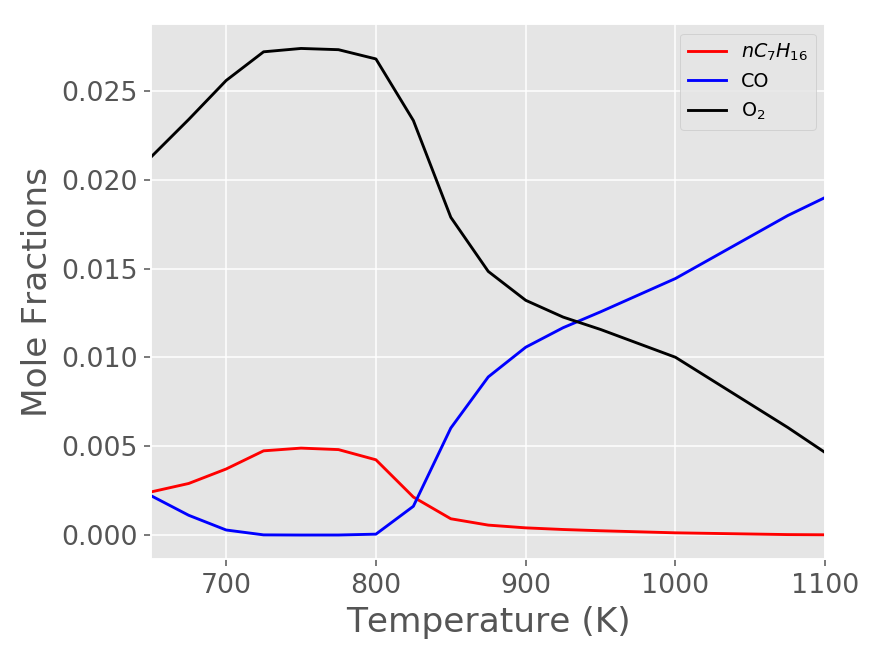

In [91]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook

plt.figure()
plt.plot(tempDependence.index, tempDependence['NC7H16'], 'r-', label=r'$nC_{7}H_{16}$')
plt.plot(tempDependence.index, tempDependence['CO'], 'b-', label='CO')
plt.plot(tempDependence.index, tempDependence['O2'], 'k-', label='O$_{2}$')


#plt.plot(expData['T'], expData['NC7H16'],'ro', label=r'$nC_{7}H_{16} (exp)$')
#plt.plot(expData['T'], expData['CO'],'b^', label='CO (exp)')
#plt.plot(expData['T'], expData['O2'],'ks', label='O$_{2}$ (exp)')

plt.xlabel('Temperature (K)')
plt.ylabel(r'Mole Fractions')

plt.xlim([650, 1100])
plt.legend(loc=1);